# CNN for MNIST dataset

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import math
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Read MNIST data here...
mnist_dir='C:\\Users\\talha\\Documents\\datasets\\mnist'
datasets = tf.contrib.learn.datasets.mnist.load_mnist(mnist_dir) # Downloads into mnist_dir
type(datasets)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting C:\Users\talha\Documents\datasets\mnist/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting C:\Users\talha\Documents\datasets\mnist/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting C:\Users\talha\Documents\datasets\mnist/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting C:\Users\talha\Documents\datasets\mnist/t10k-labels-idx1-ubyte.gz


tensorflow.contrib.learn.python.learn.datasets.base.Datasets

In [3]:
#help(datasets)
train=datasets.__getitem__(0)
validation=datasets.__getitem__(1)
test=datasets.__getitem__(2)
# train --> images, labels, num_examples
(train_images, train_labels, train_numEx) = (train.images, train.labels, train.num_examples)
(validation_images, validation_labels, validation_numEx) = (validation.images, validation.labels, validation.num_examples)
(test_images, test_labels, test_numEx) = (test.images, test.labels, test.num_examples)

print(train_images.shape, validation_images.shape, test_images.shape)

(55000, 784) (5000, 784) (10000, 784)


In [4]:
mnist_model_config = {'input' : {'img_dims' : [28, 28, 1], 'size': 784},
                      'output': {'num_classes' : 10},
                      'conv1' : {'filters' : 32, 'filter_size' : [3,3,1,32], 'stride' : [1,1,1,1], 'padding' : 'VALID'}, 
                      'conv2' : {'filters' : 64, 'filter_size' : [5,5,32,64], 'stride' : [1,1,1,1], 'padding' : 'VALID'},
                      'pool1' : {'filter_size' : [1,2,2,1], 'stride' : [1,2,2,1]},
                      'pool2' : {'filter_size' : [1,2,2,1], 'stride' : [1,2,2,1]},
                      'fc1' : {'in_size': 4*4*64, 'size' : 1024},
                      'fc2' : {'in_size': 1024, 'size' : 10}}

In [5]:
def plot_image(input_):
    plt.imshow(np.reshape(input_, (28, 28)), cmap="gray")
    return plt

def plot_activations(activations):
    print ("Plotting conv layer outputs: ")
    filters = activations.shape[3] # get number of filters/activations
    plt.figure(1, figsize=(20,20)) 
    columns = 6
    rows = math.ceil(filters / columns) + 1
    for i in range(filters):
        plt.subplot(rows, columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(activations[0,:,:,i], interpolation="nearest", cmap="gray")

def plot_filters(model_filters):
    """
    Plots only first covolution layer fitlers.
    """
    print ("Plotting Covolution Layer Filters: ")
    num_filters = model_filters.shape[3] # get number of filters/activations
    print (model_filters.shape)
    plt.figure(1, figsize=(20,20)) 
    columns = 6
    rows = math.ceil(num_filters / columns) + 1
    for i in range(num_filters):
        plt.subplot(rows, columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(model_filters[:,:,0,i], interpolation="nearest", cmap="gray")
      
    
def get_weight(shape):
    weight = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(weight)

def get_bias(shape):
    bias = tf.constant(0.1, shape=shape)
    return tf.Variable(bias)

def conv2d(x, W, strides=[1,1,1,1], padding='VALID'):
    return tf.nn.conv2d(x, W, strides=strides, padding=padding)

def max_pool(x, kernel_size=[1, 2, 2, 1], strides=[1,2,2,1], padding='VALID'):
    return tf.nn.max_pool(x, ksize=kernel_size, strides=strides, padding=padding)

def init_model_weights(model_config):
    """
    Gets model configuration dictionary as a parameter and initializes the model weights
    @param model_config: a dictionary containing model configuration 
    @returns a dictionary containing initialized model weights
    """
    W_conv1 = get_weight(shape=model_config['conv1']['filter_size'])
    b_conv1 = get_bias([model_config['conv1']['filters']])

    W_conv2 = get_weight(shape=model_config['conv2']['filter_size'])
    b_conv2 = get_bias([model_config['conv2']['filters']])

    W_fc1 = get_weight(shape=[model_config['fc1']['in_size'], model_config['fc1']['size']])
    b_fc1 = get_bias([model_config['fc1']['size']])

    W_fc2 = get_weight(shape=[model_config['fc2']['in_size'], model_config['fc2']['size']])
    b_fc2 = get_bias([model_config['fc2']['size']])
    
    return {'W_conv1':W_conv1, 'b_conv1':b_conv1, 
            'W_conv2':W_conv2, 'b_conv2':b_conv2, 
            'W_fc1':W_fc1, 'b_fc1' : b_fc1,
            'W_fc2':W_fc2, 'b_fc2':b_fc2}

def cnn_model(x, model_config):
    """
    Defines a CNN model 
    @param model_config: a dictionary specifying model configuration
    @returns output of the logits layer
    """
    # initialize model weights
    model_weights = init_model_weights(model_config)
    
    # Reshape input images
    input_images = tf.reshape(x, np.concatenate(
                                    ([-1], model_config['input']['img_dims'])))
    
    # Conv 1
    conv1 = tf.nn.relu(conv2d(
                        x=input_images, W=model_weights['W_conv1'], 
                        strides= model_config['conv1']['stride']) + 
                       model_weights['b_conv1'])
    # Pool 1
    pool1 = max_pool(conv1, kernel_size=model_config['pool1']['filter_size'], 
                     strides=model_config['pool1']['stride'])

    # Conv 2
    conv2 = tf.nn.relu(conv2d(
                        x=pool1, W=model_weights['W_conv2'], 
                        strides=model_config['conv2']['stride']) + 
                       model_weights['b_conv2'])
    # Pool 2
    pool2 = max_pool(conv2, kernel_size=model_config['pool2']['filter_size'], 
                     strides=model_config['pool2']['stride'])

    # Flatten
    pool2_flat = tf.reshape(pool2, [-1, model_config['fc1']['in_size']])

    # FC Layer
    fc1 = tf.nn.relu(tf.matmul(pool2_flat, model_weights['W_fc1']) + model_weights['b_fc1'])

    # Logits
    logits = tf.matmul(fc1, model_weights['W_fc2']) + model_weights['b_fc2']
    
    return (conv1, conv2, fc1, logits, model_weights)

In [6]:
train_iters=8
batch_size = 100
train_examples = train.num_examples
learning_rate = 1e-4

In [7]:
with tf.device('/cpu:0'):
    
    # Placholders for input
    x = tf.placeholder(tf.float32, shape=[None, mnist_model_config['input']['size']])
    y_ = tf.placeholder(tf.float32, shape=[None, mnist_model_config['output']['num_classes']])

    (conv1, conv2, fc1, logits, model_weights) = cnn_model(x, mnist_model_config)

    W_conv1 = model_weights['W_conv1']
    W_conv2 = model_weights['W_conv2']

    #Visualization
    #conv1_min = tf.reduce_min(W_conv1)
    #conv1_max = tf.reduce_min(W_conv1)
    #conv1_norm = (W_conv1 - conv1_min) / (conv1_max - conv1_min)
    # to tf.image_summary format [batch_size, height, width, channels]
    #conv1_transposed = tf.transpose(conv1_norm, [3, 0, 1, 2])


    # Define loss and optimizer
    cross_entropy_loss = tf.reduce_mean(
                        tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=logits))

    train_op = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy_loss)
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    # Initialize the variables
    init = tf.global_variables_initializer()

    
sess = tf.Session()
sess.run(init)

# Training cycle
for epoch in range(train_iters):
    avg_acc = 0.
    avg_cost = 0.
    total_batch = int(train_examples/batch_size)

    # Loop over all batches
    for i in range(total_batch):
        offset = (i * batch_size) % (train_examples)
        batch_x = train_images[offset:offset+batch_size]
        batch_y = tf.one_hot(train_labels[offset:offset+batch_size], 
                             depth=mnist_model_config['output']['num_classes']).eval(session=sess)

        # Run training step and cost op 
        t, c, a = sess.run(
                        [train_op, cross_entropy_loss, accuracy], 
                        feed_dict={x: batch_x, y_: batch_y}
                        )

        # Compute average cost
        avg_cost += c 
        avg_acc += a
    
    avg_cost /= total_batch
    avg_acc /= total_batch

    print("Epoch: " + str(epoch+1) + ", cost = " + str(avg_cost))  
    print("Epoch: " + str(epoch+1) + ", Training data accuracy = " + str(avg_acc))

Epoch: 1, cost = 0.467558586347
Epoch: 1, Training data accuracy = 0.865927273211
Epoch: 2, cost = 0.149076148648
Epoch: 2, Training data accuracy = 0.956127276204
Epoch: 3, cost = 0.101733368739
Epoch: 3, Training data accuracy = 0.969854552096
Epoch: 4, cost = 0.0787322252055
Epoch: 4, Training data accuracy = 0.97674546361
Epoch: 5, cost = 0.064341005774
Epoch: 5, Training data accuracy = 0.981309101473
Epoch: 6, cost = 0.0541071636627
Epoch: 6, Training data accuracy = 0.984436374252
Epoch: 7, cost = 0.0463834330065
Epoch: 7, Training data accuracy = 0.986400010044
Epoch: 8, cost = 0.0399235276201
Epoch: 8, Training data accuracy = 0.988454554948


In [8]:
accuracy = sess.run(accuracy, feed_dict={x: test_images,
                                         y_: tf.one_hot(test_labels, 
                                            depth=mnist_model_config['output']['num_classes']).eval(session=sess)})

print ("Accuracy on test data = " + str(accuracy * 100) + "%")

Accuracy on test data = 98.189997673%


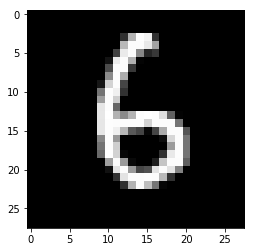

In [10]:
import random
selected_image_index = random.randint(1,100)
selected_image = test_images[selected_image_index]
plot_image(selected_image).show()

## Plotting activations of the first and second CONV layers for above image

Plotting conv layer outputs: 


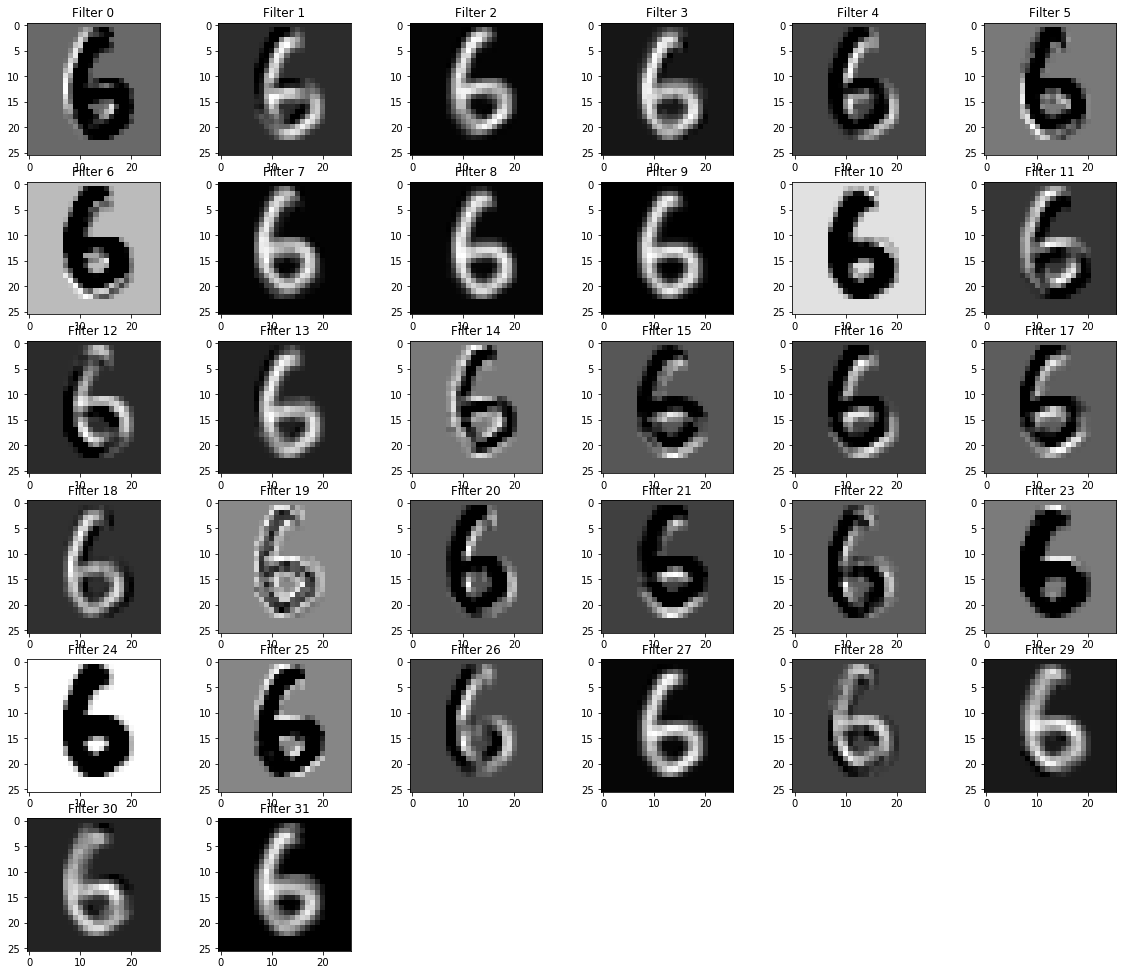

In [11]:
conv1_out = sess.run(conv1,feed_dict={x:np.reshape(selected_image,[1,784],order='F')})
plot_activations(conv1_out)

Plotting conv layer outputs: 


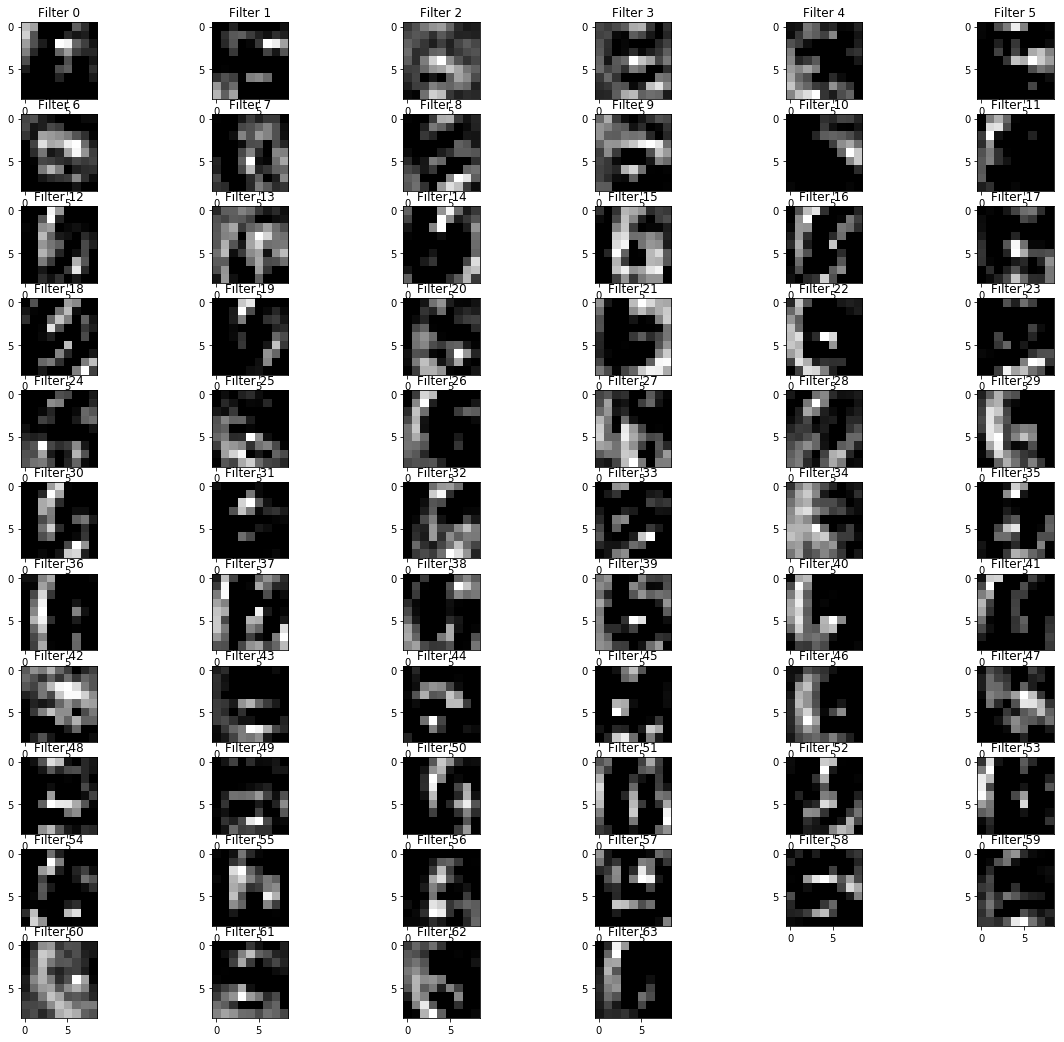

In [12]:
conv2_out = sess.run(conv2,feed_dict={x:np.reshape(selected_image,[1,784],order='F')})
plot_activations(conv2_out)

## Plotting some test images, true labels and predicted labels

In [13]:
import random
_starting_at = random.randint(0,100)
_ending_at = _starting_at + 9

images_to_test = test_images[_starting_at:_ending_at]
labels_images_to_test = test_labels[_starting_at:_ending_at]
print(images_to_test.shape)

prediction = tf.nn.softmax(logits)
pred = sess.run(prediction, feed_dict={x: images_to_test,
                                         y_: tf.one_hot(labels_images_to_test, 
                                            depth=mnist_model_config['output']['num_classes']).eval(session=sess)})

pred_class = tf.argmax(pred, 1)

print(labels_images_to_test)
model_predictions = pred_class.eval(session=sess)
print(model_predictions)

(9, 784)
[5 6 0 4 1 9 5 7 8]
[5 6 0 4 1 9 5 7 8]


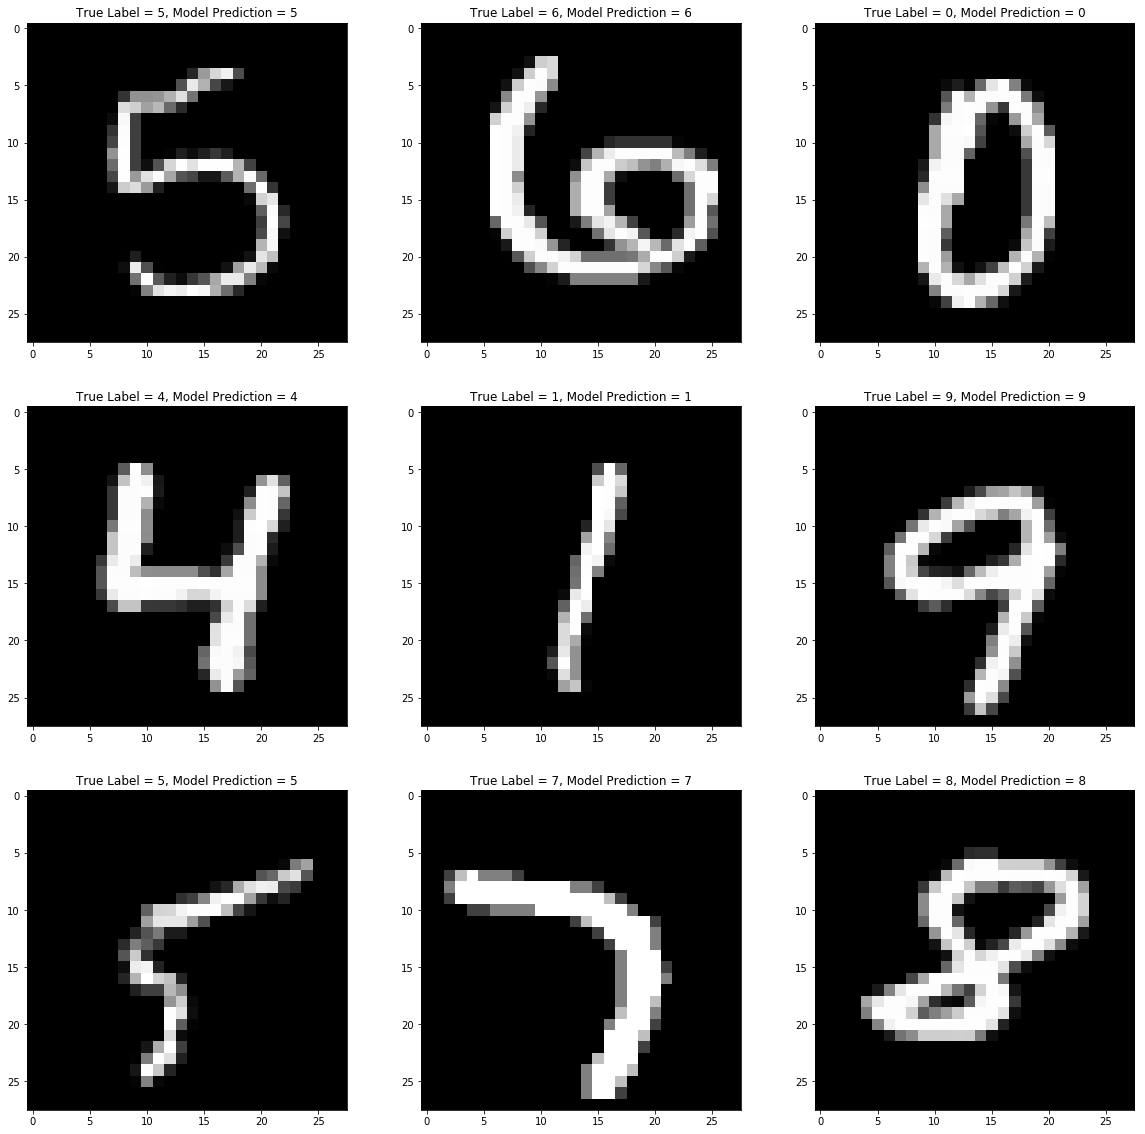

In [14]:
plt.figure(1, figsize=(20,20))
imgs = np.reshape(images_to_test, (9,28,28))
rows = 3
columns = 3
for i in range(9):
    plt.subplot(rows, columns, i+1)
    plt.title("True Label = " + str(labels_images_to_test[i]) + 
              ", Model Prediction = " + str(model_predictions[i]))
    plt.imshow(imgs[i,:,:], cmap="gray")

## Plotting Conv Layer 1 filters

Plotting Covolution Layer Filters: 
(3, 3, 1, 32)


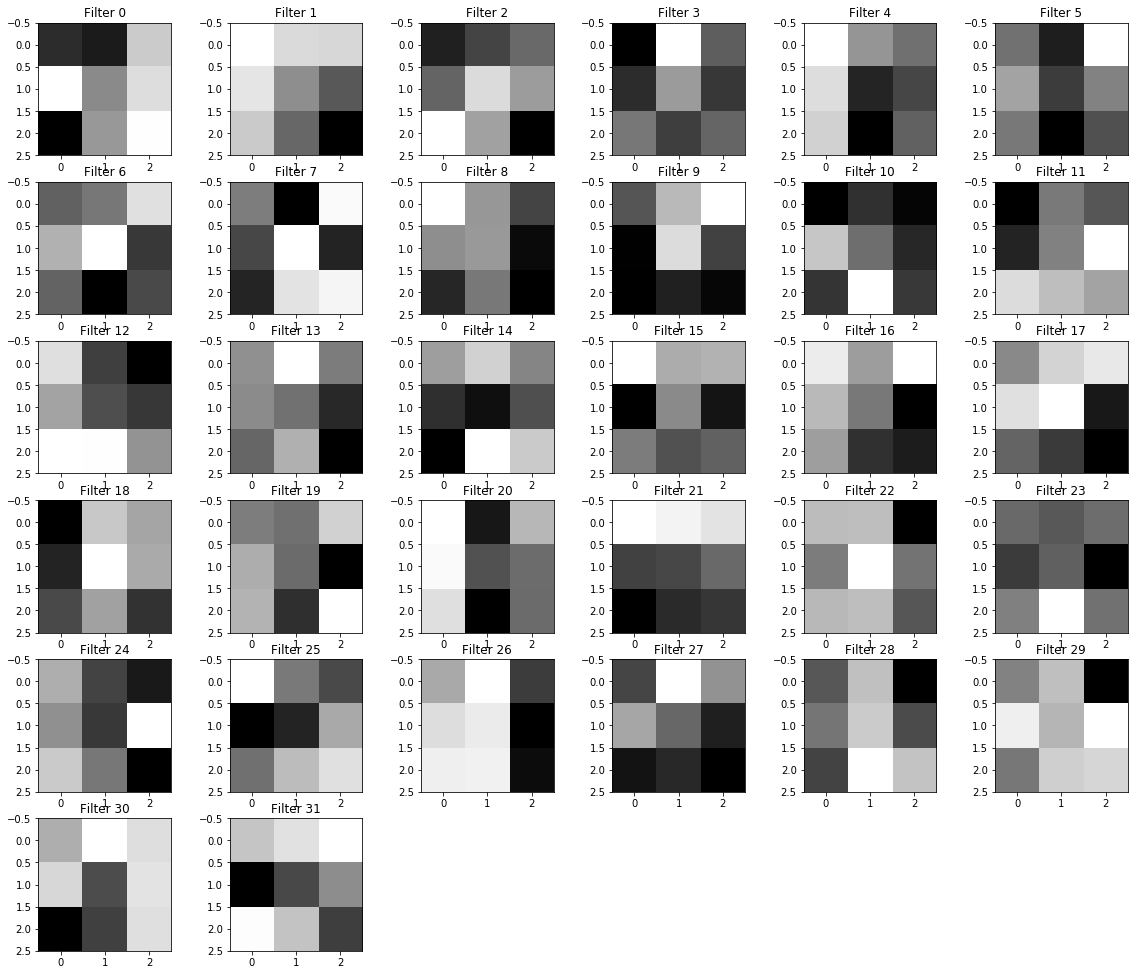

In [15]:
plot_filters(W_conv1.eval(session=sess))

## Plotting some Conv Layer 2 filters

Plotting Covolution Layer Filters: 
(5, 5, 32, 32)


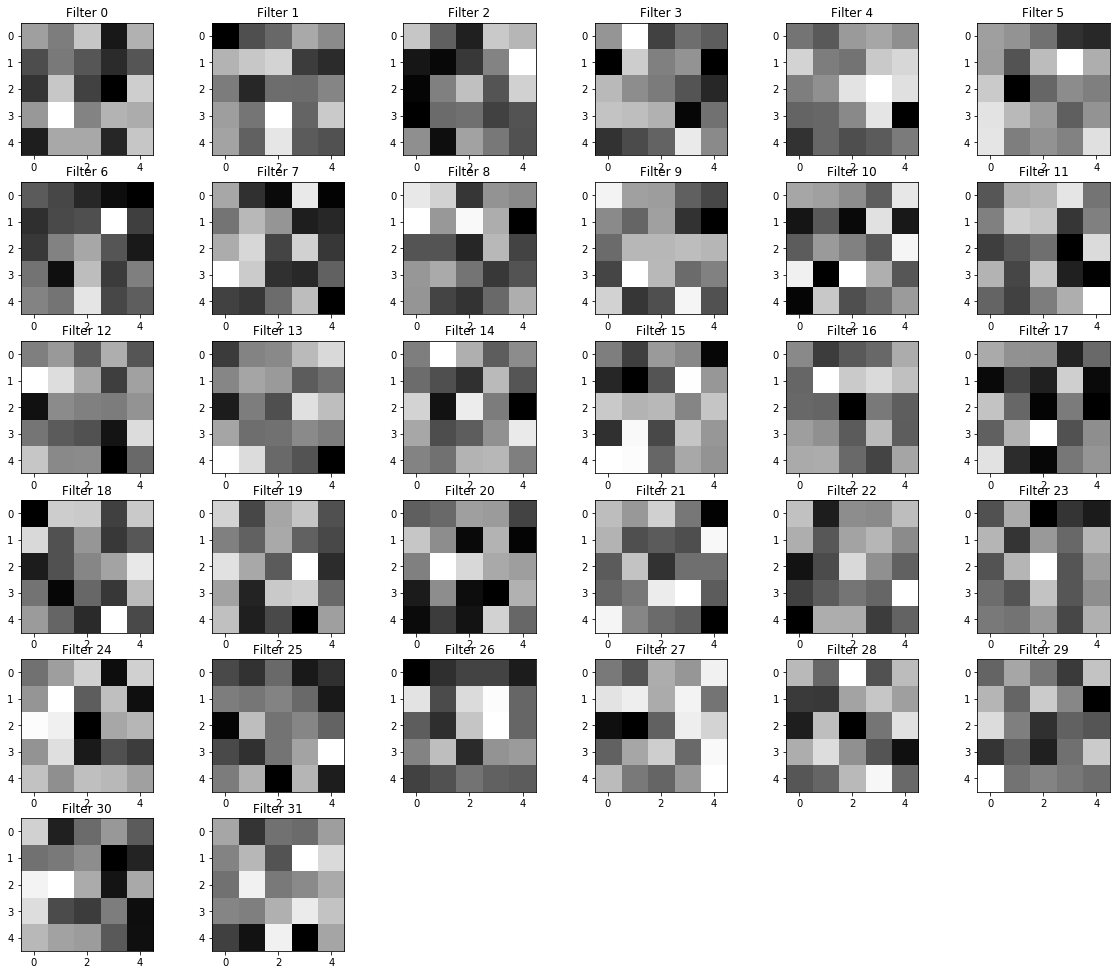

In [16]:
plot_filters(tf.reshape(model_weights['W_conv2'].eval(session=sess)[:,:,:,np.arange(0,32)], [5,5,32,32]).eval(session=sess))

In [17]:
# Close the session
sess.close()